In [1]:
from PIL import Image
from PIL import ImageOps
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random

root = Path(".")

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer4 = nn.Sequential(
#             nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer4a = nn.Sequential(
#             nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer5 = nn.Sequential(
#             nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer6 = nn.Sequential(
#             nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer7 = nn.Sequential(
#             nn.Conv1d(256, 512, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
        self.output = nn.Sequential(
            nn.Linear(2048, 2))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer4a(out)
#         out = self.layer5(out)
#         out = self.layer6(out)
#         out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.output(out)
        return out

In [3]:
class dataset:
    def __init__(self, directory):
        self.directory = directory
        self.index = str(directory)[-3:]
        self.name = str(directory)[-3:]
        self.num_images = len([file for file in os.listdir(directory) if ".tif" in file])
        self.resolution = Image.open(self.directory / os.listdir(self.directory)[0]).convert('RGB').size
        self.filepaths = [directory / file for file in os.listdir(directory) if ".tif" in file]
#         self.imagetensors = {file: transforms.ToTensor()(ImageOps.autocontrast(Image.open(file).convert('L').resize((256,256)))).cuda().squeeze() \
#                              for file in self.filepaths}

        self.ground_truth = np.loadtxt(directory / ".." / ".." / "output" / self.index / "indices.txt", dtype=float)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def sample(self, file, coordinates):
        return self.imagetensors[file][coordinates]
    def controls(self):
        total = np.shape(self.ground_truth)[0]*np.shape(self.ground_truth)[1]
        negative_count = np.shape(self.ground_truth[np.where(self.ground_truth==0)])[0]
        positive_count = total-negative_count
        negatives = list(zip(np.where(self.ground_truth==0)[0], np.where(self.ground_truth==0)[1]))
        picked_negatives = random.sample(negatives, positive_count)
        return picked_negatives
    def positives(self):
        return list(zip(np.where(self.ground_truth!=0)[0], np.where(self.ground_truth!=0)[1]))
    def tensor(self, p, coordinates):
        labels = torch.zeros(1, dtype=torch.int64, device=self.device)
        labels[0] = 1 if p==1 else 0
        rawdata = torch.zeros((1, self.num_images), device=self.device)
        for t, file in enumerate(self.filepaths):
            rawdata[0, t] = self.sample(file, coordinates)
        frames_averaged = 1
        rawdata = rawdata[0, :]
#         rawdata = self.moving_average(rawdata[0, :], frames_averaged)
        data = torch.zeros((1, self.num_images-frames_averaged+1), device=self.device)
        for i in range(data.size(1)):
            data[0, i] = rawdata[i]
        data.requires_grad_(False)
        return labels, data
    @staticmethod
    def moving_average(a, n=3) :
        ret = torch.cumsum(a, dim=0, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    def create_batch(self, batch_size):
        positives = self.positives()
        controls = self.controls()
        all_data = positives+controls
        labels = [1 for _ in positives] + [0 for _ in controls]
        packages = list(zip(labels, all_data))
        packages = random.sample(packages, len(packages))
        assert len(packages)%batch_size==0
        n_used = 0
        def gen_batch():
            nonlocal packages
            nonlocal n_used
            if n_used == len(packages):
                return []
            else:
                labels = torch.stack([self.tensor(p, coordinate)[0] for p,coordinate in packages[n_used:n_used+batch_size]])
                inputs = torch.stack([self.tensor(p, coordinate)[1] for p,coordinate in packages[n_used:n_used+batch_size]])
                n_used += batch_size
                return labels, inputs
        return gen_batch
    
class sdataset:
    def __init__(self, directory):
        self.directory = directory
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.positives = [directory / "positives" / file for file in os.listdir(directory / "positives")]
        self.negatives = [directory / "negatives" / file for file in os.listdir(directory / "negatives")]
        self.all = list(zip([1 for _ in self.positives]+[0 for _ in self.negatives], self.positives+self.negatives))
        self.time = 512
        self.allshuffle = random.sample(self.all, len(self.all))
    def load(self, file):
        return np.loadtxt(file, dtype=float)
    def tensor(self, p, file):
        label = torch.zeros(1, dtype=torch.int64, device=self.device)
        label[0] = 1 if p==1 else 0
        data = torch.zeros(self.time, device=self.device)
        npdata = self.load(file)
        for t in range(self.time):
            data[t] = npdata[t]
        data.requires_grad_(True)
        return label, data
    def create_batch(self, batch_size):
        assert len(self.allshuffle)%batch_size==0
        n_used = 0
        def gen_batch():
            nonlocal n_used
            if n_used == len(self.allshuffle):
                return None
            else:
                labels = torch.stack([self.tensor(p, coordinate)[0] for p,coordinate in self.allshuffle[n_used:n_used+batch_size]])
                inputs = torch.stack([self.tensor(p, coordinate)[1] for p,coordinate in self.allshuffle[n_used:n_used+batch_size]])
                inputs = inputs[:, None, :]
                n_used += batch_size
                return labels, inputs
        return gen_batch

In [4]:
data = sdataset(root / "output" / "training_data")
# batch_generator = data.create_batch(10)
# batch = batch_generator()
# batch[0].requires_grad

In [ ]:
data = dataset(root / "data" / "002")
f = data.create_batch(6)
x = f()
batches = []
while len(x) > 0:
    batches += [x]
    x = f()

In [5]:
net = ConvNet()
net.cuda()
criterion = nn.CrossEntropyLoss(reduction='mean')
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=.01)

In [6]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

7394


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=.001)

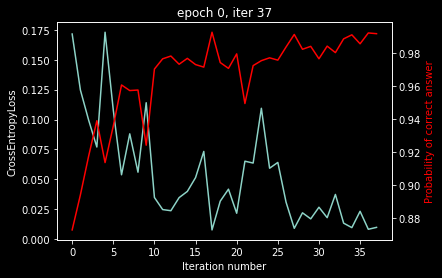

In [ ]:
from IPython import display

def accuracy(outputs, labels):
    # first axis is batch size
    probabilities = torch.nn.Softmax(1)(outputs)
    scores = []
    for i, index in enumerate(labels):
        scores += [probabilities[i, index.item()].item()]
    return np.mean(scores)
    

plt.style.use('dark_background')

fig, ax = plt.subplots(1,1)
ax2 = ax.twinx()
loss_ax = []
accuracy_ax = []
batch_generator = data.create_batch(100)
for epoch in range(10):
    batch = batch_generator()
    i=0
    while batch is not None:
        optimizer.zero_grad()
        labels, inputs = batch[0].squeeze(), batch[1]
        labels, inputs = labels.cuda(), inputs.cuda()
#         a = list(net.parameters())[0].clone() 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         b = list(net.parameters())[0].clone()
#         print("Model updating? ", not(torch.equal(a,b)))

        loss_ax += [loss.item()]
        accuracy_ax += [accuracy(outputs, labels)]
#         plt.gca().cla()
# #         plt.plot(range(len(loss_ax[-100:])), 10*np.log10(loss_ax[-100:]))#, s=9, marker='s')

#         plt.plot(range(len(loss_ax)), loss_ax)#, s=9, marker='s')
#         plt.title("epoch %d, iter %d"%(epoch, i))
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        
#         plt.plot(range(len(loss_ax[-100:])), 10*np.log10(loss_ax[-100:]))#, s=9, marker='s')
        ax.cla()
        ax2.cla()
        
        ax.plot(loss_ax)
        ax.set_title("epoch %d, iter %d"%(epoch, i))
        ax.set_xlabel("Iteration number")
        ax.set_ylabel("CrossEntropyLoss")
        ax2.plot(accuracy_ax, color='red')
        ax2.set_ylabel("Probability of correct answer", color='red')
#         ax2.set_ylim(0, 1)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        batch = batch_generator()
        i += 1


In [ ]:
from IPython import display

plt.style.use('dark_background')

fig, ax = plt.subplots(1,1)
loss_ax = []
for epoch in range(200):
    cloned_batch = [(label.clone().detach(), data.clone().detach()) for label, data in batches]
    for i, item in enumerate(cloned_batch): 
        optimizer.zero_grad()

        # get the inputs; data is a list of [inputs, labels]
        labels, inputs = torch.squeeze(item[0]), item[1]
        labels, inputs = labels.cuda(), inputs.cuda()

#         inputs.requires_grad_()
#         print(labels.shape)
#         print(labels.reshape(labels.size(0), -1).shape)
        # forward + backward + optimize
#         a = list(net.parameters())[0].clone() 
        
        outputs = net(inputs)

        #         print("outputs:", outputs, "labels:", labels)
#         print("probabilities", torch.nn.functional.softmax(outputs, dim=1))
        loss = criterion(outputs, labels)
#         print(loss)
        loss.backward()
        optimizer.step()
#         b = list(net.parameters())[0].clone()
#         print("Model updating? ", not(torch.equal(a,b)))

        # print statistics
        loss_ax += [loss.item()]
        plt.gca().cla()
        plt.scatter(range(len(loss_ax[-100:])), 10*np.log10(loss_ax[-100:]), s=9, marker='s')
        plt.title("epoch %d, iter %d"%(epoch, i))
        display.clear_output(wait=True)
        display.display(plt.gcf()) 

#         if i==0:
#         print(epoch, i, loss.item(), "label is:", labels.item())
    print('Finished Training')

In [ ]:
cloned_batch = [(label.clone().detach(), data.clone().detach()) for label, data in batches]
for i, item in enumerate(cloned_batch): 
    print(item)
    # get the inputs; data is a list of [inputs, labels]
    labels, inputs = torch.squeeze(item[0]), item[1]
    labels, inputs = labels.cuda(), inputs.cuda()
    print(net(inputs))
